In [3]:
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Layer
# import torch
# import torch.nn as nn
import re
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.ops.numpy_ops import np_utils
# from transformers import BertModel, TFBertModel 
# import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel, DistilBertTokenizer, TFDistilBertModel, AutoTokenizer
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


2025-04-02 11:37:31.774450: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 11:37:32.015361: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 11:37:32.271928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743586652.666103    6835 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743586652.747757    6835 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743586653.148268    6835 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [4]:
# downloaded from https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data
fake_data=pd.read_csv("./input/Fake.csv")
real_data=pd.read_csv("./input/True.csv")

In [5]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


/tmp/ipykernel_6835/2371052887.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels, rotation=45)


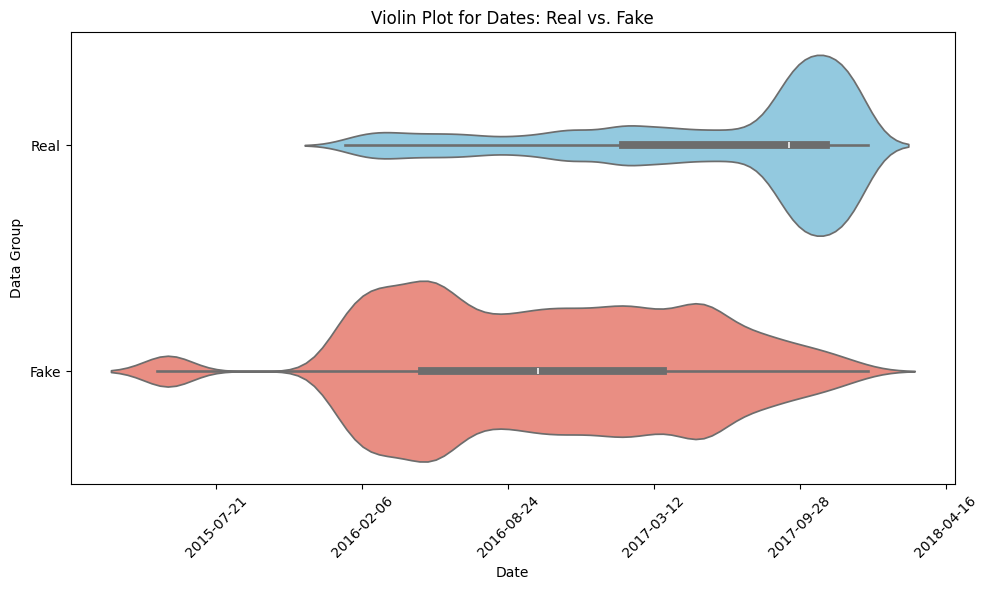

In [ ]:
# Convert the 'date' columns to datetime.
real_data['date'] = pd.to_datetime(real_data['date'].str.strip(), format="%B %d, %Y", errors='coerce')
fake_data['date'] = pd.to_datetime(fake_data['date'].str.strip(), format="%B %d, %Y", errors='coerce')

# Define a valid date range.
valid_min = pd.to_datetime("2000-01-01")
valid_max = pd.to_datetime("2020-12-31")

# Filter out rows with dates outside the valid range.
real_data = real_data[(real_data['date'] >= valid_min) & (real_data['date'] <= valid_max)]
fake_data = fake_data[(fake_data['date'] >= valid_min) & (fake_data['date'] <= valid_max)]

# Convert dates to ordinal numbers for plotting.
real_data['date_ordinal'] = real_data['date'].apply(lambda x: x.toordinal())
fake_data['date_ordinal'] = fake_data['date'].apply(lambda x: x.toordinal())

# Add a column to distinguish between real and fake data.
real_data['Group'] = 'Real'
fake_data['Group'] = 'Fake'

# Combine the dataframes.
combined = pd.concat([real_data, fake_data])

# Create a horizontal violin plot.
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='date_ordinal', y='Group', data=combined,
                    palette={'Real': 'skyblue', 'Fake': 'salmon'}, orient='h', hue='Group', legend=False)

plt.title("Date Distribution: Real vs. Fake")
plt.xlabel("Date")
plt.ylabel("Data Group")

# Adjust x-axis ticks to show formatted dates.
ticks = ax.get_xticks()
tick_labels = [pd.Timestamp.fromordinal(int(t)).strftime("%Y-%m-%d") for t in ticks]
ax.set_xticklabels(tick_labels, rotation=45)

plt.tight_layout()
plt.show()

In [8]:
print("News Subjects:")
print(f"-> Real News:\n{real_data['subject'].value_counts()}")
print(f"\n-> Fake News:\n{fake_data['subject'].value_counts()}")

News Subjects:
-> Real News:
subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

-> Fake News:
subject
News               9050
US_News             783
Middle-east         778
politics            643
left-news           436
Government News     178
Name: count, dtype: int64


<Axes: ylabel='subject'>

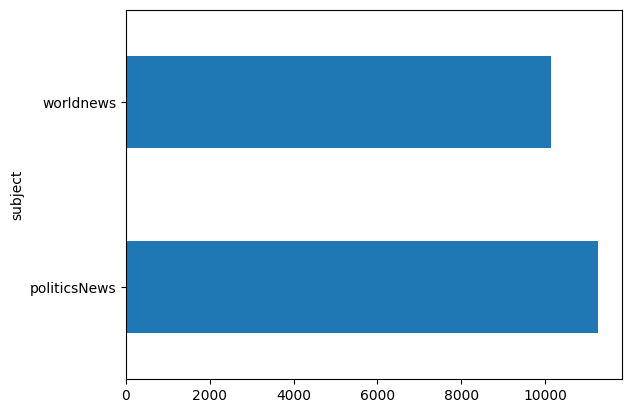

In [ ]:
real_data['subject'].value_counts().plot(kind='barh', title='Subjects - Real News', color='skyblue', figsize=(10, 6))

<Axes: ylabel='subject'>

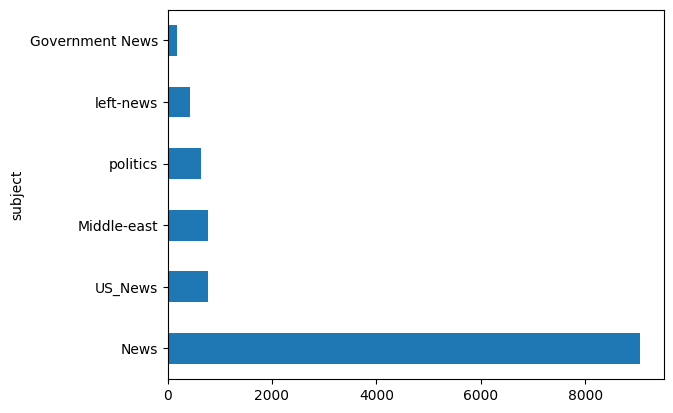

In [ ]:
fake_data['subject'].value_counts().plot(kind='barh', title='Subjects - Fake News', color='salmon', figsize=(10, 6))s

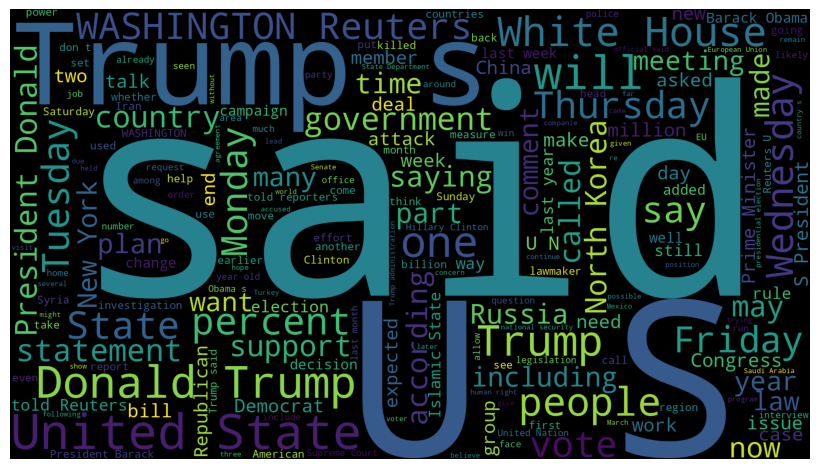

In [11]:
# REAL DATA
wordcld_text=" ".join(real_data["text"].tolist())
wordcloud=WordCloud(width=1920,height=1080).generate(wordcld_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

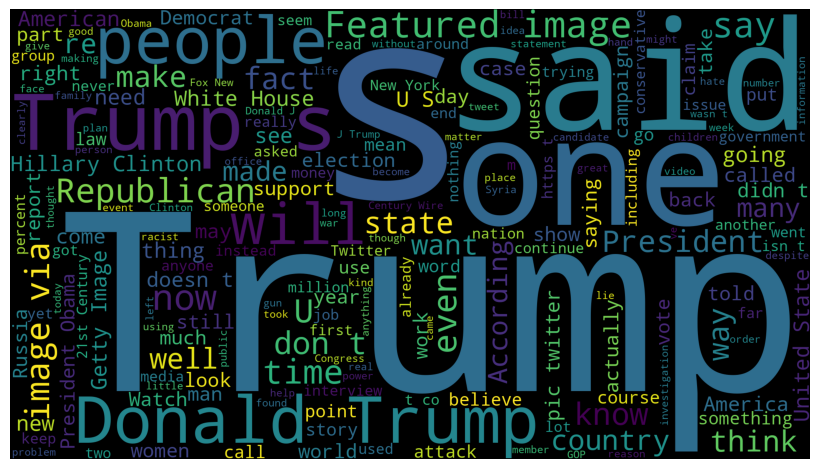

In [12]:
# FAKE DATA
wordcld_text=" ".join(fake_data["text"].tolist())
wordcloud=WordCloud(width=1920,height=1080).generate(wordcld_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [13]:
# 631 times only headline available
print("Missing texts in real_data:", len(real_data[real_data["text"].str.strip() == ""]))
print("Missing texts in fake_data:", len(fake_data[fake_data["text"].str.strip() == ""]))

Missing texts in real_data: 1
Missing texts in fake_data: 39


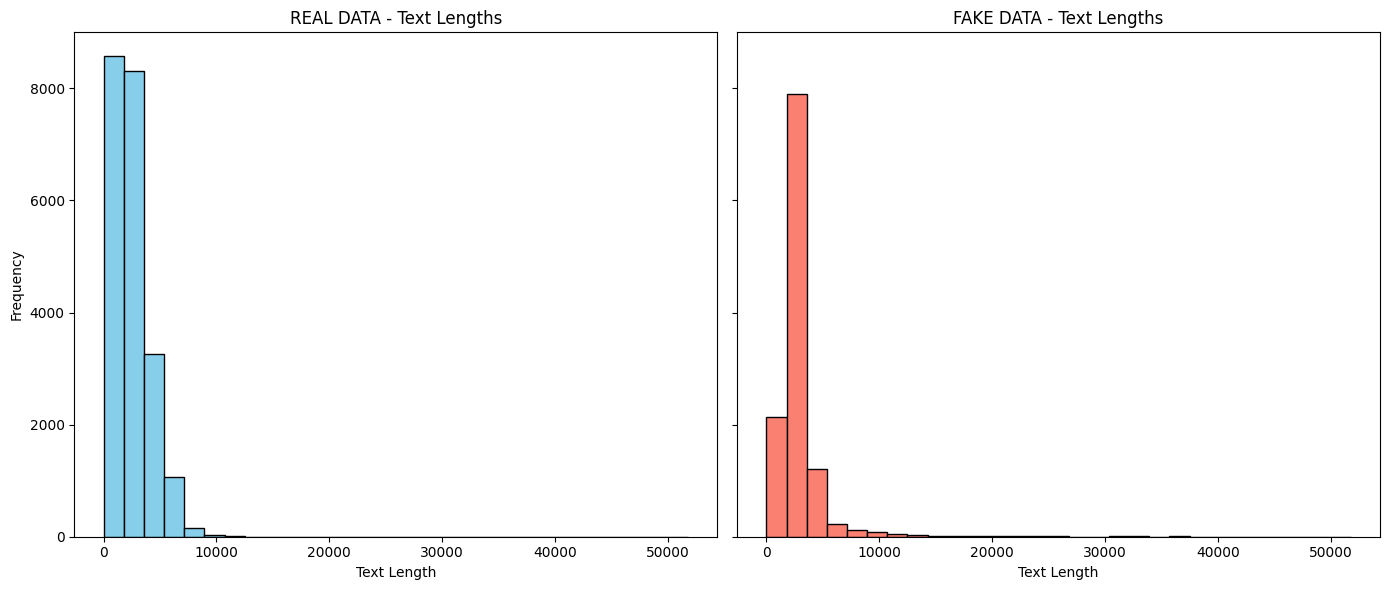

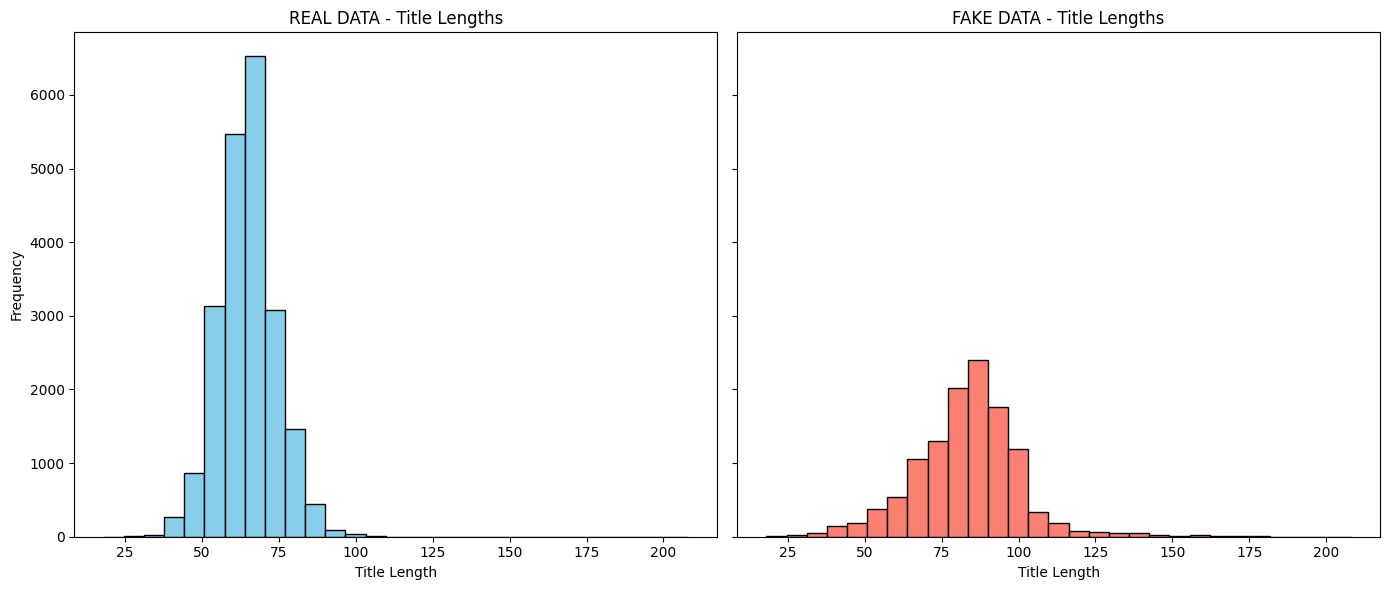

In [14]:
real_data['text_length'] = real_data['text'].apply(len)
real_data['title_length'] = real_data['title'].apply(len)
fake_data['text_length'] = fake_data['text'].apply(len)
fake_data['title_length'] = fake_data['title'].apply(len)

# Define bin ranges based on combined min/max values
text_min = min(real_data['text_length'].min(), fake_data['text_length'].min())
text_max = max(real_data['text_length'].max(), fake_data['text_length'].max())

title_min = min(real_data['title_length'].min(), fake_data['title_length'].min())
title_max = max(real_data['title_length'].max(), fake_data['title_length'].max())

# Define bin edges for consistent intervals
text_bins = np.linspace(text_min, text_max, 30)  # Adjust 30 for desired granularity
title_bins = np.linspace(title_min, title_max, 30)

# For Text Lengths Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
axes[0].hist(real_data['text_length'], bins=text_bins, color='skyblue', edgecolor='black')
axes[0].set_title('REAL DATA - Text Lengths')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')

axes[1].hist(fake_data['text_length'], bins=text_bins, color='salmon', edgecolor='black')
axes[1].set_title('FAKE DATA - Text Lengths')
axes[1].set_xlabel('Text Length')

plt.tight_layout()
plt.show()

# For Title Lengths Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
axes[0].hist(real_data['title_length'], bins=title_bins, color='skyblue', edgecolor='black')
axes[0].set_title('REAL DATA - Title Lengths')
axes[0].set_xlabel('Title Length')
axes[0].set_ylabel('Frequency')

axes[1].hist(fake_data['title_length'], bins=title_bins, color='salmon', edgecolor='black')
axes[1].set_title('FAKE DATA - Title Lengths')
axes[1].set_xlabel('Title Length')

plt.tight_layout()
plt.show()

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Compute token counts for both real and fake data for 'text' and 'title'.
real_data['text_token_count'] = real_data['text'].apply(lambda x: len(tokenizer.tokenize(x)))
real_data['title_token_count'] = real_data['title'].apply(lambda x: len(tokenizer.tokenize(x)))

fake_data['text_token_count'] = fake_data['text'].apply(lambda x: len(tokenizer.tokenize(x)))
fake_data['title_token_count'] = fake_data['title'].apply(lambda x: len(tokenizer.tokenize(x)))

# Prepare DataFrames for violin plots.
df_text_tokens = pd.DataFrame({
    'Token Count': list(real_data['text_token_count']) + list(fake_data['text_token_count']),
    'Data': ['Real'] * len(real_data) + ['Fake'] * len(fake_data)
})

df_title_tokens = pd.DataFrame({
    'Token Count': list(real_data['title_token_count']) + list(fake_data['title_token_count']),
    'Data': ['Real'] * len(real_data) + ['Fake'] * len(fake_data)
})

# Create violin plots side by side for texts and titles.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot for text token counts.
sns.violinplot(x='Data', y='Token Count', data=df_text_tokens, 
               ax=axes[0], palette={'Real': 'skyblue', 'Fake': 'salmon'}, hue='Data', legend=False)
axes[0].set_title('Violin Plot of Text Token Counts')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Token Count')

# Violin plot for title token counts.
sns.violinplot(x='Data', y='Token Count', data=df_title_tokens, 
               ax=axes[1], palette={'Real': 'skyblue', 'Fake': 'salmon'}, hue='Data', legend=False)
axes[1].set_title('Violin Plot of Title Token Counts')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Token Count')

plt.tight_layout()
plt.show()

## Preprocessing

Extreme Bias due to "(Reuters)":

In [ ]:
# check real_data for indicators other than just the text for being real
count = real_data["text"].str.contains(r"\(Reuters\)").sum()
print(f"The percentage of real news articles containing '(Reuters)': {np.round(count/len(real_data)*100,2)}%")

The percentage of real news articles containing '(Reuters)': 99.21%


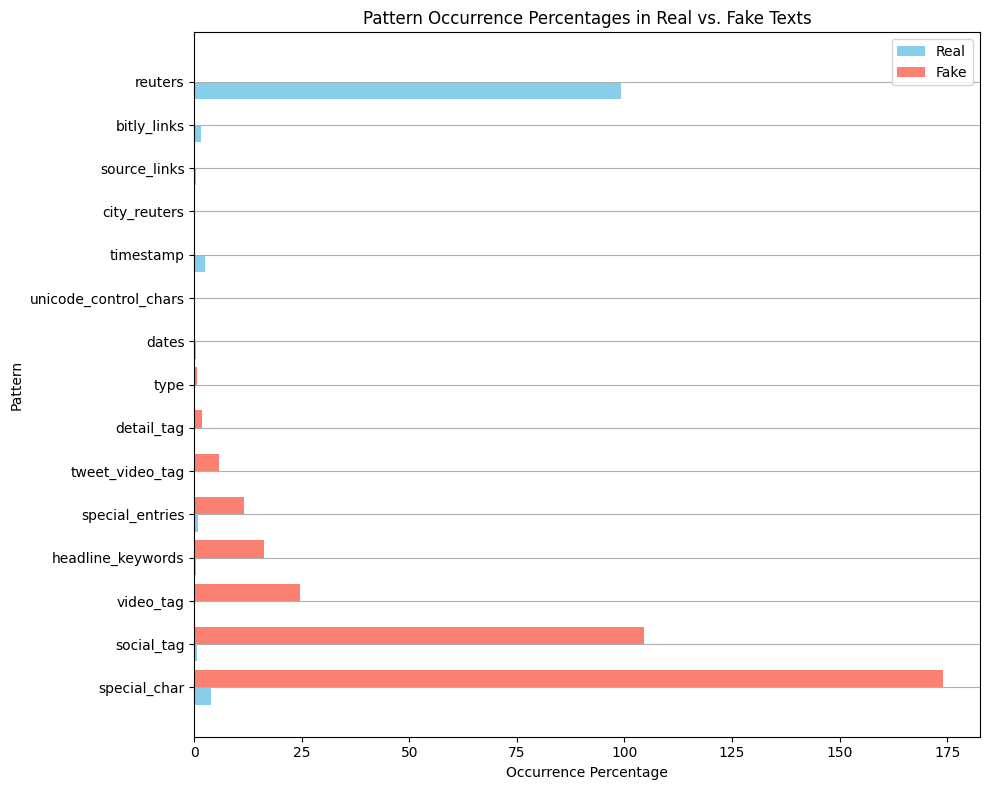

In [ ]:
# Define pattern variables.
city_reuters_pattern = r'^(\(.*\))*\s*[A-Z][A-Z\s,./-]*\(Reuters\)\s*-\s*'
timestamp_pattern = r'\[\d{3,4}\s+\w+\]'
dates_pattern = r'\((?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)(\.)?\s\d+\)'
source_links_pattern = r'\s*--\s*Source link:\s*(?:\([^)]+\)\s*)+$'
bitly_links_pattern = r'bit\.ly/[^\)\]\s]+'
reuters_pattern = r'\(Reuters\) -'
social_tag_pattern = r'\(\@\w+\)'
special_char_pattern = r'\@'
unicode_control_chars_pattern = r'[\u200E\u200F\u202A-\u202E]'
headline_keywords_pattern = (r'(WATCH|BREAKING|WTF|BUSTED|EMBARASSING|WTF|WHOA|OOPS|'
                             r'EXPOSED|REVEALED|BOMBSHELL|CORRUPTION|YOU’RE FIRED|WEIRD|'
                             r'SPINELESS|VINDICATION|UNHINGED|UNPRECEDENTED|CREEPY|LOL|ALERT|'
                             r'WOW|Unbelievable|UNCOVERED|SICK|RIGGED|OUTRAGE|MUTINY|'
                             r'SICKENING|FACEPALM|FRAUD|SCARY|HILARIOUS|SCAMPAIGN|'
                             r'WHOOPS|SHOCKING|Collapse|LISTEN|Shameful|VICTORY|Hypocrites|FINALLY|#FakeNews'
                             r'RECKLESS|PROPAGANDA|EPIC FAIL|DIGITAL TYRANNY|^\w*\s*FAKE\s*NEWS\w*|CRIMINAL'
                             r'HOLLYWOOD WITCHCRAFT|SHOCKER|RT EXCLUSIVE|MASS INTEGRATION|WARNING|STUNNER|SOLDIER):')
video_tag_pattern = r'\[video\]|\(video\)'
detail_tag_pattern = r'\(DETAIL(S)?|Click on link for details\)'
tweet_video_tag_pattern = (r'\('
                           r'(?:(?:'
                           r'(?:TWEET(?:S)?|VIDEO(?:S)?|AUDIO(?:S)?|IMAGE(?:S)?|PHOTO(?:S)?|SCREENSHOT(?:S)?)'
                           r'\s*(?:/|,)\s*'
                           r'(?:TWEET(?:S)?|VIDEO(?:S)?|AUDIO(?:S)?|IMAGE(?:S)?|PHOTO(?:S)?|SCREENSHOT(?:S)?)'
                           r')|'
                           r'TWEET(?:S)?|'
                           r'Live\s*video'
                           r')\)')
type_pattern = r'\([A-Z\s]+\)$'
special_entries_pattern = r'EP\s*#\d+|BOILER\s+ROOM|Episode\s*#\d+|DRIVE\s+BY\s+WIRE|SHOUT!\s+POLL|POLL:' # drop special entries like podcasts

# Create dictionary mapping descriptive names to the pattern variables.
patterns = {
    'city_reuters': city_reuters_pattern,
    'timestamp': timestamp_pattern,
    'dates': dates_pattern,
    'source_links': source_links_pattern,
    'bitly_links': bitly_links_pattern,
    'reuters': reuters_pattern,
    'social_tag': social_tag_pattern,
    'special_char': special_char_pattern,
    'unicode_control_chars': unicode_control_chars_pattern,
    'headline_keywords': headline_keywords_pattern,
    'video_tag': video_tag_pattern,
    'detail_tag': detail_tag_pattern,
    'tweet_video_tag': tweet_video_tag_pattern,
    'type': type_pattern,
    'special_entries': special_entries_pattern
}

# Example definitions for your data:
# (Replace these with your actual dataframes or lists)
# Assume real_data and fake_data are dictionaries or DataFrames with "title" and "text" keys.
real_texts = [f"{t}: {d}" for t, d in zip(real_data["title"], real_data["text"])]
fake_texts = [f"{t}: {d}" for t, d in zip(fake_data["title"], fake_data["text"])]

# Initialize dictionaries to store counts.
pattern_counts_real = {name: 0 for name in patterns.keys()}
pattern_counts_fake = {name: 0 for name in patterns.keys()}

# Count matches in real_texts.
for text in real_texts:
    for name, pattern in patterns.items():
        matches = re.findall(pattern, text, flags=re.IGNORECASE)
        pattern_counts_real[name] += len(matches)

# Count matches in fake_texts.
for text in fake_texts:
    for name, pattern in patterns.items():
        matches = re.findall(pattern, text, flags=re.IGNORECASE)
        pattern_counts_fake[name] += len(matches)

# Calculate ratios by dividing by the number of texts in each set.
n_real = len(real_texts)
n_fake = len(fake_texts)
# Calculate percentages
ratio_real_percent = {name: (count / n_real) * 100 for name, count in pattern_counts_real.items()}
ratio_fake_percent = {name: (count / n_fake) * 100 for name, count in pattern_counts_fake.items()}

# Sort patterns by occurrence in fake texts for better visualization
sorted_patterns = sorted(ratio_fake_percent.keys(), key=lambda k: ratio_fake_percent[k], reverse=True)
real_values = [ratio_real_percent[k] for k in sorted_patterns]
fake_values = [ratio_fake_percent[k] for k in sorted_patterns]

# Horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))
y = np.arange(len(sorted_patterns))
ax.barh(y - 0.2, real_values, height=0.4, label='Real', color='skyblue', align='center')
ax.barh(y + 0.2, fake_values, height=0.4, label='Fake', color='salmon', align='center')

# Labels and title
ax.set_xlabel('Occurrence Percentage')
ax.set_ylabel('Pattern')
ax.set_title('Pattern Occurrence Percentages in Real vs. Fake Texts')
ax.set_yticks(y)
ax.set_yticklabels(sorted_patterns)
ax.legend()
ax.grid(axis='x')

plt.tight_layout()
plt.show()


In [19]:
def remove_city_reuters(text):
    return re.sub(city_reuters_pattern, '', text)

def remove_timestamp(text, verbose=False):
    if verbose:
        matches = re.findall(timestamp_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Timestamp matches:", matches)
    return re.sub(timestamp_pattern, '', text, flags=re.IGNORECASE)

def remove_dates(text, verbose=False):
    if verbose:
        matches = re.findall(dates_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Date matches:", matches)
    return re.sub(dates_pattern, '', text, flags=re.IGNORECASE)

def remove_source_links(text, verbose=False):
    if verbose:
        matches = re.findall(source_links_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Source link matches:", matches)
    return re.sub(source_links_pattern, '', text, flags=re.IGNORECASE)

def remove_bitly_links(text, verbose=False):
    if verbose:
        matches = re.findall(bitly_links_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Bitly link matches:", matches)
    return re.sub(bitly_links_pattern, '', text, flags=re.IGNORECASE)

def remove_reuters(text, verbose=False):
    if verbose:
        matches = re.findall(reuters_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Reuters matches:", matches)
    return re.sub(reuters_pattern, '', text, flags=re.IGNORECASE)

def remove_social_tag(text, verbose=False):
    if verbose:
        matches = re.findall(social_tag_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Social tag matches:", matches)
    return re.sub(social_tag_pattern, '', text, flags=re.IGNORECASE)

def remove_special_char(text, verbose=False):
    if verbose:
        matches = re.findall(special_char_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Special char matches:", matches)
    return re.sub(special_char_pattern, '', text, flags=re.IGNORECASE)

def remove_unicode_control_chars(text, verbose=False):
    if verbose:
        matches = re.findall(unicode_control_chars_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Unicode control character matches:", matches)
    return re.sub(unicode_control_chars_pattern, '', text, flags=re.IGNORECASE)

def remove_headline_keywords(text, verbose=False):
    if verbose:
        matches = re.findall(headline_keywords_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Headline keywords matches:", matches)
    return re.sub(headline_keywords_pattern, '', text, flags=re.IGNORECASE)

def remove_video_tag(text, verbose=False):
    if verbose:
        matches = re.findall(video_tag_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Video tag matches:", matches)
    return re.sub(video_tag_pattern, '', text, flags=re.IGNORECASE)

def remove_detail_tag(text, verbose=False):
    if verbose:
        matches = re.findall(detail_tag_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Detail tag matches:", matches)
    return re.sub(detail_tag_pattern, '', text, flags=re.IGNORECASE)

def remove_tweet_video_tag(text, verbose=False):
    if verbose:
        matches = re.findall(tweet_video_tag_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Tweet/Video tag matches:", matches)
    return re.sub(tweet_video_tag_pattern, '', text, flags=re.IGNORECASE)

def remove_type(text, verbose=False):
    if verbose:
        matches = re.findall(type_pattern, text)
        if matches:
            print("Type matches:", matches)
    return re.sub(type_pattern, '', text)

def drop_special_entries(df, verbose=False):
    df_filtered = df[~df['title'].str.contains(special_entries_pattern, case=False, na=False)]
    if verbose:
        print(f"Dropped {len(df) - len(df_filtered)} special entries.")
    return df_filtered

def clean_text_real(text, verbose=False):
    text = text.strip()
    text = remove_city_reuters(text)
    text = remove_unicode_control_chars(text, verbose)
    text = remove_dates(text, verbose)
    text = remove_timestamp(text, verbose)
    text = remove_source_links(text, verbose)
    text = remove_bitly_links(text, verbose)
    text = remove_reuters(text, verbose)
    text = remove_social_tag(text, verbose)
    text = remove_special_char(text, verbose)
    text = text.strip()
    return text

def clean_text_fake(text, verbose=False):
    text = text.strip()
    text = remove_unicode_control_chars(text, verbose)
    text = remove_headline_keywords(text, verbose)
    text = remove_dates(text, verbose)
    text = remove_detail_tag(text, verbose)
    text = remove_tweet_video_tag(text, verbose)
    text = remove_video_tag(text, verbose)
    text = remove_type(text, verbose)
    text = remove_bitly_links(text, verbose)
    text = remove_social_tag(text, verbose)
    text = remove_special_char(text, verbose)
    text = text.strip()
    return text

In [20]:
real_data['cleaned_text'] = real_data['text'].apply(lambda x: clean_text_real(x, verbose=False))
real_data["cleaned_title"] = real_data["title"].apply(lambda x: clean_text_real(x, verbose=False))
real_data = drop_special_entries(real_data, verbose=True)
real_data[['cleaned_title', 'cleaned_text']].head()

Dropped 4 special entries.


,cleaned_title,cleaned_text
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...


In [21]:
fake_data['cleaned_text'] = fake_data['text'].apply(lambda x: clean_text_fake(x, verbose=False))
fake_data['cleaned_title'] = fake_data['title'].apply(lambda x: clean_text_fake(x, verbose=False))
fake_data = drop_special_entries(fake_data, verbose=True)
fake_data[['cleaned_title', 'cleaned_text']].head()

Dropped 296 special entries.


,cleaned_title,cleaned_text
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk..."
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...


In [22]:
# remove (Reuters) because it would be an indicator for real news
#real_data["text"] = real_data["text"].str.replace(r"\(Reuters\)", "", regex=True)

In [23]:
real_data[["cleaned_title"]].to_csv("./input/Real_cleaned_title.csv", index=False)
fake_data[["cleaned_title"]].to_csv("./input/Fake_cleaned_title.csv", index=False)

In [24]:
real_data[["cleaned_title","cleaned_text"]].to_csv("./input/Real_cleaned.csv", index=False)
fake_data[["cleaned_title","cleaned_text"]].to_csv("./input/Fake_cleaned.csv", index=False)

In [25]:
fake_data["label"]="fake"
real_data["label"]="real"

In [26]:
final_data = pd.concat([fake_data,real_data]).reset_index(drop=True)
final_data.head(10)

,title,text,subject,date,date_ordinal,Group,text_length,title_length,text_token_count,title_token_count,cleaned_text,cleaned_title,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,736694,Fake,2893,79,728,15,Donald Trump just couldn t wish all Americans ...,Donald Trump Sends Out Embarrassing New Year’s...,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,736694,Fake,1898,69,385,11,House Intelligence Committee Chairman Devin Nu...,Drunk Bragging Trump Staffer Started Russian C...,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,736693,Fake,3597,90,928,17,"On Friday, it was revealed that former Milwauk...",Sheriff David Clarke Becomes An Internet Joke ...,fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,736692,Fake,2774,78,704,18,"On Christmas day, Donald Trump announced that ...",Trump Is So Obsessed He Even Has Obama’s Name ...,fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,736688,Fake,2346,70,475,11,Pope Francis used his annual Christmas Day mes...,Pope Francis Just Called Out Donald Trump Duri...,fake
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,2017-12-25,736688,Fake,1741,82,365,16,The number of cases of cops brutalizing and ki...,Racist Alabama Cops Brutalize Black Boy While ...,fake
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,2017-12-23,736686,Fake,2166,83,479,17,Donald Trump spent a good portion of his day a...,"Fresh Off The Golf Course, Trump Lashes Out At...",fake
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,2017-12-23,736686,Fake,2224,87,452,17,In the wake of yet another court decision that...,Trump Said Some INSANELY Racist Stuff Inside T...,fake
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,2017-12-22,736685,Fake,2772,102,572,23,Many people have raised the alarm regarding th...,Former CIA Director Slams Trump Over UN Bullyi...,fake
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,2017-12-21,736684,Fake,1644,81,346,21,Just when you might have thought we d get a br...,Brand-New Pro-Trump Ad Features So Much A** Ki...,fake


In [27]:
# 631 times only headline available
final_data[final_data["text"].str.strip() == ""]

,title,text,subject,date,date_ordinal,Group,text_length,title_length,text_token_count,title_token_count,cleaned_text,cleaned_title,label
9561,(VIDEO) THE INCREDIBLE JOHN BOLTON: WHAT HILL’...,,politics,2015-05-24,735742,Fake,1,89,0,23,,THE INCREDIBLE JOHN BOLTON: WHAT HILL’S E-MAIL...,fake
9563,MUST WATCH VIDEO: DO YOU REALLY WANT FOUR YEAR...,,politics,2015-05-23,735741,Fake,1,56,0,13,,MUST WATCH VIDEO: DO YOU REALLY WANT FOUR YEAR...,fake
9564,[Video] TED CRUZ SHOWS THE GOP How To Effectiv...,,politics,2015-05-23,735741,Fake,1,94,0,20,,TED CRUZ SHOWS THE GOP How To Effectively Shut...,fake
9582,MUST WATCH COMEDY: ROOM FULL OF DEMS ARE ASKED...,,politics,2015-05-20,735738,Fake,1,106,0,26,,MUST WATCH COMEDY: ROOM FULL OF DEMS ARE ASKED...,fake
9583,STORE OWNER BASHES LIBERAL OBAMAITES AS HE SHU...,,politics,2015-05-20,735738,Fake,1,68,0,15,,STORE OWNER BASHES LIBERAL OBAMAITES AS HE SHU...,fake
9586,(VIDEO) JUDGE NAPOLITANO FILLS US IN ON ORDER ...,,politics,2015-05-20,735738,Fake,1,86,0,23,,JUDGE NAPOLITANO FILLS US IN ON ORDER FOR “ROL...,fake
9588,(VIDEO) TREY GOWDY GETS REAL AT COMMUNITY POLI...,,politics,2015-05-20,735738,Fake,1,79,0,20,,TREY GOWDY GETS REAL AT COMMUNITY POLICING HEA...,fake
9595,MUST WATCH VIDEO: HILLARY SUPPORTERS ACTUALLY ...,,politics,2015-05-19,735737,Fake,1,67,0,12,,MUST WATCH VIDEO: HILLARY SUPPORTERS ACTUALLY ...,fake
9596,MUST WATCH VIDEO: BUSH EERILY WARNS US ABOUT ISIS,,politics,2015-05-19,735737,Fake,1,49,0,11,,MUST WATCH VIDEO: BUSH EERILY WARNS US ABOUT ISIS,fake
9604,(VIDEO) FORMER DEFENSE SECRETARY EXPRESSES CON...,,politics,2015-05-18,735736,Fake,1,93,0,17,,FORMER DEFENSE SECRETARY EXPRESSES CONCERN OVE...,fake


In [28]:
# no missing titles
final_data[final_data["title"].str.strip() == ""]

,title,text,subject,date,date_ordinal,Group,text_length,title_length,text_token_count,title_token_count,cleaned_text,cleaned_title,label


In [29]:
final_data.isnull().sum()

title                0
text                 0
subject              0
date                 0
date_ordinal         0
Group                0
text_length          0
title_length         0
text_token_count     0
title_token_count    0
cleaned_text         0
cleaned_title        0
label                0
dtype: int64

<Axes: ylabel='label'>

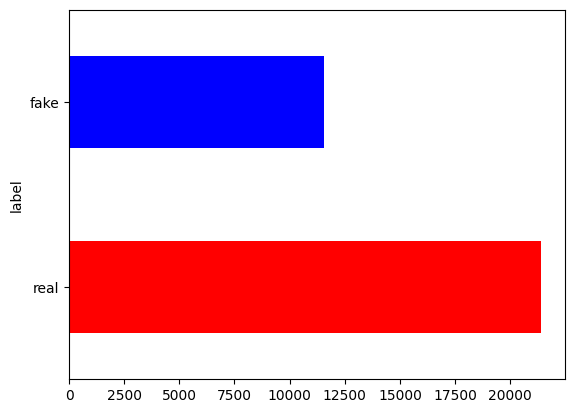

In [ ]:
# Get value counts
label_counts = final_data.label.value_counts()
# Define color mapping
colors = ['blue' if label == 'real' else 'red' for label in label_counts.index]
# Plot
label_counts.plot(kind='barh', color=colors)

In [31]:
final_data

,title,text,subject,date,date_ordinal,Group,text_length,title_length,text_token_count,title_token_count,cleaned_text,cleaned_title,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,736694,Fake,2893,79,728,15,Donald Trump just couldn t wish all Americans ...,Donald Trump Sends Out Embarrassing New Year’s...,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,736694,Fake,1898,69,385,11,House Intelligence Committee Chairman Devin Nu...,Drunk Bragging Trump Staffer Started Russian C...,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,736693,Fake,3597,90,928,17,"On Friday, it was revealed that former Milwauk...",Sheriff David Clarke Becomes An Internet Joke ...,fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,736692,Fake,2774,78,704,18,"On Christmas day, Donald Trump announced that ...",Trump Is So Obsessed He Even Has Obama’s Name ...,fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,736688,Fake,2346,70,475,11,Pope Francis used his annual Christmas Day mes...,Pope Francis Just Called Out Donald Trump Duri...,fake
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32980,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,736563,Real,2821,61,557,14,NATO allies on Tuesday welcomed President Dona...,'Fully committed' NATO backs new U.S. approach...,real
32981,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,736563,Real,800,52,166,11,"LexisNexis, a provider of legal, regulatory an...",LexisNexis withdrew two products from Chinese ...,real
32982,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,736563,Real,1950,49,420,7,In the shadow of disused Soviet-era factories ...,Minsk cultural hub becomes haven from authorities,real
32983,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,736563,Real,1199,61,234,9,Vatican Secretary of State Cardinal Pietro Par...,Vatican upbeat on possibility of Pope Francis ...,real


# Train only with titles

In [32]:
final_data['label'] = final_data['label'].map({'real':1, 'fake':0})
final_data = final_data.sample(frac=1).reset_index(drop=True)
final_data.head()

,title,text,subject,date,date_ordinal,Group,text_length,title_length,text_token_count,title_token_count,cleaned_text,cleaned_title,label
0,Egypt kills 13 militants in raid on western de...,CAIRO (Reuters) - Egyptian security forces kil...,worldnews,2017-10-27,736629,Real,2226,55,425,10,Egyptian security forces killed 13 militants d...,Egypt kills 13 militants in raid on western de...,1
1,Twitter HAMMERS Trump After He Says The Dumbe...,"On Tuesday, Donald Trump once again amped up t...",News,2017-01-03,736332,Fake,4867,89,1180,21,"On Tuesday, Donald Trump once again amped up t...",Twitter HAMMERS Trump After He Says The Dumbes...,0
2,Clinton campaign denies staffing changes in works,"WASHINGTON/MANCHESTER, N.H. (Reuters) - U.S. D...",politicsNews,2016-02-08,736002,Real,1750,49,386,8,U.S. Democratic presidential candidate Hillary...,Clinton campaign denies staffing changes in works,1
3,Watch A GOP Senate Candidate Threaten To Harm...,A Republican United States Senate candidate in...,News,2016-05-12,736096,Fake,2190,65,436,14,A Republican United States Senate candidate in...,Watch A GOP Senate Candidate Threaten To Harm ...,0
4,Clinton's lead over Trump narrows to nine poin...,NEW YORK (Reuters) - Democrat Hillary Clinton’...,politicsNews,2016-06-21,736136,Real,1455,63,287,15,Democrat Hillary Clinton’s lead over Republica...,Clinton's lead over Trump narrows to nine poin...,1


In [33]:
data_text=final_data["cleaned_title"]
data_label=final_data["label"]

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

2025-04-02 01:49:57.679708: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state = 42)

In [36]:

maxlen = 100
def tokenize(X):
    tokens = tokenizer(
        text=list(X),
        add_special_tokens=True,
        max_length=maxlen,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_attention_mask=True,
        return_token_type_ids=False,
        verbose=True
    )
    return tokens

In [37]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [38]:
X_train_token

{'input_ids': <tf.Tensor: shape=(26388, 100), dtype=int32, numpy=
array([[  101,  2160,  5997, ...,     0,     0,     0],
       [  101,  8398,  2136, ...,     0,     0,     0],
       [  101,  5569,  2602, ...,     0,     0,     0],
       ...,
       [  101, 16795,  5130, ...,     0,     0,     0],
       [  101,  6696,  4447, ...,     0,     0,     0],
       [  101,  6161,  2591, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(26388, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [39]:
class DistilBertLayer(Layer):
    def __init__(self, distilbert_model, **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        # DistilBERT returns a tuple where the first element is the last_hidden_state:
        # shape (batch_size, seq_length, hidden_size)
        outputs = self.distilbert(inputs)
        # Use the embedding of the first token ([CLS] token) as a pooled representation.
        pooled_output = outputs[0][:, 0, :]
        return pooled_output

    def get_config(self):
        config = super(DistilBertLayer, self).get_config()
        config.update({"distilbert_model": None})
        return config

    @classmethod
    def from_config(cls, config):
        # When reloading, you'll need to supply the actual distilbert_model instance.
        distilbert_model = ...  # Update with your own logic if reloading from config.
        return cls(distilbert_model, **config)

def create_model(distilbert_model, maxlen=maxlen):
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")
    
    distilbert_layer = DistilBertLayer(distilbert_model)
    pooled_output = distilbert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x = Dropout(0.5)(pooled_output)
    x = Dense(64, activation="tanh")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create the model
model = create_model(distilbert_model)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_layer   │ (None, 768)       │          0 │ attention_mask[0… │
│ (DistilBertLayer)   │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ distil_bert_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     49,216 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Compile the model
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/home/martin/FakeNewsNLP/.venv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints_title/model_{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
    mode="min"
)


In [42]:
# Train the model
history = model.fit(
    x={
        'input_ids': X_train_token['input_ids'],
        'attention_mask': X_train_token['attention_mask']
    },
    y=Y_train,
    epochs=5,
    batch_size=50,
    validation_data=(
        {
            'input_ids': X_test_token['input_ids'],
            'attention_mask': X_test_token['attention_mask']
        },
        Y_test
    ),
    callbacks=[early_stopping, reduce_lr, checkpoint_callback]
)

Epoch 1/5
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6162 - loss: 0.6734
Epoch 1: val_loss improved from inf to 0.49569, saving model to checkpoints_title/model_01-0.50.h5


528/528 ━━━━━━━━━━━━━━━━━━━━ 2452s 5s/step - accuracy: 0.6163 - loss: 0.6733 - val_accuracy: 0.7253 - val_loss: 0.4957 - learning_rate: 1.0000e-05
Epoch 2/5
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7087 - loss: 0.5583
Epoch 2: val_loss improved from 0.49569 to 0.41882, saving model to checkpoints_title/model_02-0.42.h5


528/528 ━━━━━━━━━━━━━━━━━━━━ 2451s 5s/step - accuracy: 0.7088 - loss: 0.5583 - val_accuracy: 0.8116 - val_loss: 0.4188 - learning_rate: 1.0000e-05
Epoch 3/5
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7650 - loss: 0.4897
Epoch 3: val_loss improved from 0.41882 to 0.36007, saving model to checkpoints_title/model_03-0.36.h5


528/528 ━━━━━━━━━━━━━━━━━━━━ 2458s 5s/step - accuracy: 0.7650 - loss: 0.4897 - val_accuracy: 0.8759 - val_loss: 0.3601 - learning_rate: 1.0000e-05
Epoch 4/5
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7999 - loss: 0.4386
Epoch 4: val_loss improved from 0.36007 to 0.32550, saving model to checkpoints_title/model_04-0.33.h5


528/528 ━━━━━━━━━━━━━━━━━━━━ 2456s 5s/step - accuracy: 0.8000 - loss: 0.4385 - val_accuracy: 0.8854 - val_loss: 0.3255 - learning_rate: 1.0000e-05
Epoch 5/5
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8293 - loss: 0.3949
Epoch 5: val_loss improved from 0.32550 to 0.29894, saving model to checkpoints_title/model_05-0.30.h5


528/528 ━━━━━━━━━━━━━━━━━━━━ 2452s 5s/step - accuracy: 0.8293 - loss: 0.3948 - val_accuracy: 0.8965 - val_loss: 0.2989 - learning_rate: 1.0000e-05


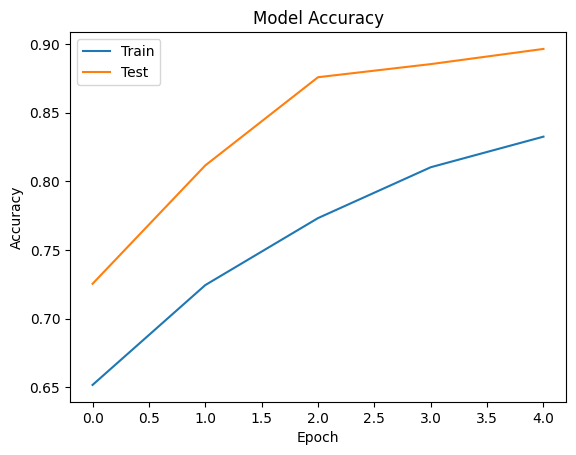

In [43]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

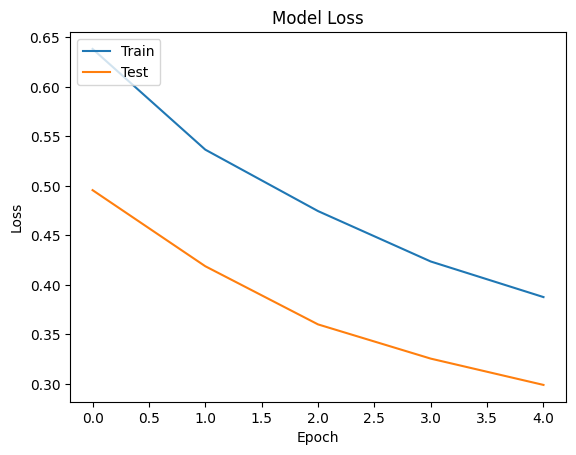

In [44]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [45]:
# Make predictions
y_pred_proba = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

207/207 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step


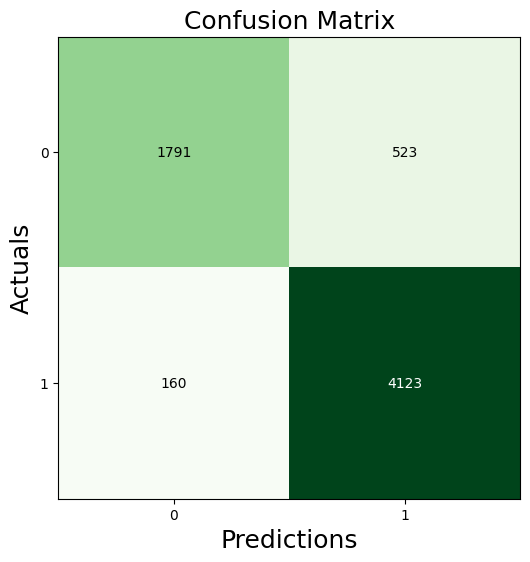

In [46]:
# Plot confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Train with only texts

In [47]:
# final_data["titleAndText"]=final_data["cleaned_title"] +": " + final_data["cleaned_text"]
# final_data=final_data[["titleAndText","label"]]
# final_data['label'] = final_data['label'].map({'real':1, 'fake':0})
# final_data = final_data.sample(frac=1).reset_index(drop=True)
# final_data.head()

In [48]:
data_text=final_data["cleaned_text"]
data_label=final_data["label"]

In [49]:
# final_data[["titleAndText","label"]].to_csv("./input/final_data.csv", index=False)

In [50]:
# bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')
# tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state = 42)

In [52]:

maxlen = 512
def tokenize(X):
    tokens = tokenizer(
        text=list(X),
        add_special_tokens=True,
        max_length=maxlen,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_attention_mask=True,
        return_token_type_ids=False,
        verbose=True
    )
    return tokens

In [53]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [54]:
X_train_token

{'input_ids': <tf.Tensor: shape=(26388, 512), dtype=int32, numpy=
array([[  101,  1996,  1057, ...,     0,     0,     0],
       [  101, 24205,  2000, ...,     0,     0,     0],
       [  101,  1996,  3424, ...,  3424,  1011,   102],
       ...,
       [  101,  3017,  9850, ...,  1012,  2720,   102],
       [  101, 10104,  1011, ..., 28276,  3803,   102],
       [  101,  1037,  2047, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(26388, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [55]:
class DistilBertLayer(Layer):
    def __init__(self, distilbert_model, **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        # DistilBERT returns a tuple where the first element is the last_hidden_state:
        # shape (batch_size, seq_length, hidden_size)
        outputs = self.distilbert(inputs)
        # Use the embedding of the first token ([CLS] token) as a pooled representation.
        pooled_output = outputs[0][:, 0, :]
        return pooled_output

    def get_config(self):
        config = super(DistilBertLayer, self).get_config()
        config.update({"distilbert_model": None})
        return config

    @classmethod
    def from_config(cls, config):
        # When reloading, you'll need to supply the actual distilbert_model instance.
        distilbert_model = ...  # Update with your own logic if reloading from config.
        return cls(distilbert_model, **config)

def create_model(distilbert_model, maxlen=maxlen):
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")
    
    distilbert_layer = DistilBertLayer(distilbert_model)
    pooled_output = distilbert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x = Dropout(0.5)(pooled_output)
    x = Dense(64, activation="tanh")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create the model
model = create_model(distilbert_model)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_layer_1 │ (None, 768)       │          0 │ attention_mask[0… │
│ (DistilBertLayer)   │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 768)       │          0 │ distil_bert_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     49,216 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Compile the model
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/home/martin/FakeNewsNLP/.venv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [57]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints_text/model_{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
    mode="min"
)




In [58]:
# Train the model
history = model.fit(
    x={
        'input_ids': X_train_token['input_ids'],
        'attention_mask': X_train_token['attention_mask']
    },
    y=Y_train,
    epochs=5,
    batch_size=50,
    validation_data=(
        {
            'input_ids': X_test_token['input_ids'],
            'attention_mask': X_test_token['attention_mask']
        },
        Y_test
    ),
    callbacks=[early_stopping, reduce_lr, checkpoint_callback]
)

Epoch 1/5


2025-04-02 05:28:28.280767: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.
2025-04-02 05:28:31.758715: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.
2025-04-02 05:28:35.502625: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.
2025-04-02 05:28:39.597818: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.
2025-04-02 05:28:43.600242: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.


449/528 ━━━━━━━━━━━━━━━━━━━━ 31:56 24s/step - accuracy: 0.6300 - loss: 0.6567

KeyboardInterrupt: 

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Make predictions
y_pred_proba = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

In [ ]:
# Plot confusion matrix
# from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()